# Global indicator project
## Calculate z scores and Aggregate sample point indicators to 250m grid-level analysis

Process:
- Evaluate local variables/indicators for sample points  
- Take average of sample point variables to 250m grid. 
    - Then we have population density (pop/area in hectares of 250m grid cell), street connectivity (average connectivity per square km of local road networks in grid cell), and daily living access (average score from 0 to 3 for access to daily living amenities in grid cell) 
- Calculate respective z-scores of pop (or dwelling) density, street connectivity and daily living  
- Sum z-scores for a walkability index calculated for 250m grid cells


In [18]:
from setup_OSMnetwork import *
from setup_local_analysis import *
from config import *

from scipy.stats import zscore
import folium

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## 1. Load pedestrain street network, pop grid and sample points stats from local folder

In [3]:
## Load pedestrain street network graphml and edge shapefile from local folder
G_proj = get_OSM_G(G_filename, OSM_folder)

In [43]:
# load sample point shapefile
sample_points_gdf = gpd.GeoDataFrame.from_file(samplepoint_stats_shapefile_path, geometry='geometry')

# change variables to float type
sample_points_gdf[['intct_den', 'Paces_bus', 'Paces_shop', 'Baces_bus', 'Baces_shop']] = sample_points_gdf[['intct_den', 'Paces_bus', 'Paces_shop', 'Baces_bus', 'Baces_shop']].astype(float)

In [44]:
# load population grid
pop_gdf = gpd.GeoDataFrame.from_file(GHS_pop_filepath, geometry='geometry')
pop_gdf['raster_val'] = pop_gdf['raster_val'].astype(float)

In [45]:
# make sure the same projection, latlong
sample_points_gdf.crs = crs
sample_points_gdf = sample_points_gdf.to_crs(pop_gdf.crs)

sample_points_gdf.crs == pop_gdf.crs

True

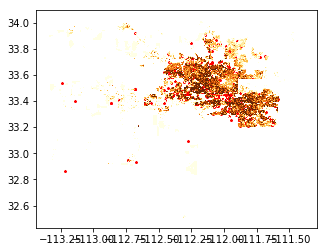

In [94]:
ax = sample_points_gdf.plot(marker='*', color='red', markersize=5)
ax = pop_gdf.plot(ax=ax, column='raster_val', scheme='quantiles', k=6, cmap='YlOrBr')

plt.show()

## 2. Aggregate sample point stats to 250m pop grid

In [84]:
df_columns = ['intct_den', 'Paces_bus', 'Paces_shop', 'Baces_bus', 'Baces_shop'] 

start = time.time()
task = "Take average of sample point variables to 250m grid for {}".format(placename)

# associate analysis_area with aggregate population estimates
for col in df_columns:
    # create null field for stats values
    pop_gdf[col] = np.nan 
    pop_gdf[col] = pop_gdf[col].astype('float')
    for row in range(1, len(pop_gdf)):
        area_id = pop_gdf[(row-1):row].index
        grid_polygon = pop_gdf['geometry'].iloc[row-1]
        mask = sample_points_gdf.centroid.within(grid_polygon)
        grid_stats = np.average(sample_points_gdf[mask][col])
        pop_gdf.loc[area_id, col] = grid_stats

#drop null grid
pop_gdf_notnull = pop_gdf.dropna()
#make sure values as float type
pop_gdf_notnull['raster_val'] = pop_gdf['raster_val'].astype('float')

print('Completed task "{}" with total {} grids in {:,.2f} seconds'.format(
    task, len(pop_gdf), time.time() - start)) 


## 3. Standardize gird stats to z scores
https://stackoverflow.com/questions/24761998/pandas-compute-z-score-for-all-columns

In [87]:
# claculate z-scores for variables in sample point dataframe columns
def cal_zscores_df(df, df_columns):
    for col in df_columns:
        col_zscore = col + '_zscore'
        df[col_zscore] = df[[col]].apply(zscore)
    return df

In [88]:
df_columns = ['raster_val', 'intct_den', 'intct_den', 'Paces_bus', 'Paces_shop', 'Baces_bus', 'Baces_shop']
pop_grid_zscore_df = cal_zscores_df(pop_gdf_notnull, df_columns)
pop_grid_zscore_df.head()

,raster_val,geometry,intct_den,Paces_bus,Paces_shop,Baces_bus,Baces_shop,raster_val_zscore,intct_den_zscore,Paces_bus_zscore,Paces_shop_zscore,Baces_bus_zscore,Baces_shop_zscore
227,55.552124,POLYGON ((-112.7755713368735 33.96208090051934...,73.022034,0.0,0.0,0.0,0.0,-0.546229,-0.226970,-1.006354,-1.036471,-0.823697,-1.045250
502,1.420686,POLYGON ((-112.6780199203052 33.92375712972463...,82.559822,0.0,0.0,0.0,0.0,-1.026411,0.148773,-1.006354,-1.036471,-0.823697,-1.045250
611,0.797012,POLYGON ((-112.1449711083425 33.90982121307201...,98.245763,1.0,1.0,1.0,1.0,-1.031943,0.766724,1.002125,0.973014,1.224764,0.964847
778,9.877358,POLYGON ((-112.0787755042426 33.88194937976678...,84.991121,1.0,0.0,1.0,0.0,-0.951395,0.244555,1.002125,-1.036471,1.224764,-1.045250
1114,3.410752,"POLYGON ((-111.8453489003112 33.864529483951, ...",125.190765,1.0,0.0,1.0,0.0,-1.008758,1.828228,1.002125,-1.036471,1.224764,-1.045250


## 4. Sum z-scores for a walkability index

In [89]:
# Sum z-scores for a walkability index calculated for 250m grid cells
pop_grid_zscore_df['walk_index'] = pop_grid_zscore_df['raster_val_zscore'] + pop_grid_zscore_df['intct_den_zscore'] + pop_grid_zscore_df['Paces_bus_zscore'] + pop_grid_zscore_df['Paces_shop_zscore']

## Walkability index webmap

In [90]:
pop_grid_zscore_gdf = gpd.GeoDataFrame(pop_grid_zscore_df, geometry='geometry')

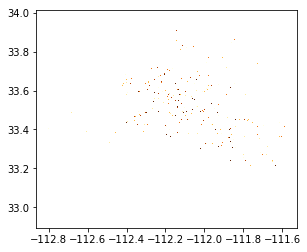

In [91]:
ax = pop_grid_zscore_gdf.plot(column='walk_index', scheme='quantiles', k=6, cmap='YlOrBr')
plt.show()

In [122]:
# load study region boundary file and project to lat-long
clipping_boundary = gpd.GeoDataFrame.from_file(boundary_filepath)
clipping_boundary = clipping_boundary.to_crs(to_crs)

pop_grid_zscore_gdf.crs = to_crs
pop_grid_zscore_gdf_json = pop_grid_zscore_gdf.to_json()

In [132]:
centroid = clipping_boundary.geometry.centroid
bins = list(pop_grid_zscore_gdf['walk_index'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]))

# initialise map
m = folium.Map(location=[centroid.y.mean(), centroid.x.mean()], zoom_start=9, tiles=None, control_scale=True, prefer_canvas=True)

m.add_tile_layer(tiles='OpenStreetMap', name='OpenStreetMap', overlay=True, active=True)

# add data as choropleth
b = folium.Choropleth(clipping_boundary.to_json(),
                           name = 'study region boundary',
                           fill_color = 'red',
                           fill_opacity = 0,
                           line_color = 'red', 
                           highlight = False).add_to(m)

c = folium.Choropleth(pop_grid_zscore_gdf_json, data=pop_grid_zscore_gdf['walk_index'], bins=bins,
                      columns=['geometry', 'walk_index'], 
                      key_on='feature.properties.geometry', 
                      highlight=True, fill_color='YlGnBu',
                      fill_opacity = 0.5, line_color = 'green', line_opacity=0.5,
                      legend_name='Walkability index per pixel',
                      name='Walkability index, 250m grid', reset=True).add_to(m)


# add mouseover tooltip to the countries
c.geojson.add_child(folium.features.GeoJsonTooltip(['walk_index']))

folium.LayerControl().add_to(m)

# save map
map_name = '02_walk_index_{}.html'.format(placename)
m.save('../maps/{}'.format(map_name))
print("\nPlease inspect results using interactive map saved in project maps folder: {}\n".format(map_name)) 


Please inspect results using interactive map saved in project maps folder: 02_walk_index_phoenix.html

